In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
loan_train = pd.read_csv('Data/loan_train_sampled.csv')
loan_test = pd.read_csv('Data/loan_test.csv')

### Spliting the training data into labeled and unlabeled data

In [3]:
# Split labeled data into smaller labeled set and larger unlabeled set
labeled_data, unlabeled_data = train_test_split(loan_train, test_size=0.8, random_state=0)

# Separate test set for final evaluation
X_test = loan_test.loc[:, loan_test.columns != 'loan_status']

print("Labeled data shape:", labeled_data.shape)
print("Unlabeled data shape:", unlabeled_data.shape)

Labeled data shape: (3356, 39)
Unlabeled data shape: (13424, 39)


In [4]:
iteration = 0

### The model is trained on labeled data and the unlabeled data exhibiting high-confidence predictions (with high probabilities) with pseudo labels are added iteratively to the labeled data.

In [5]:
while len(unlabeled_data) > 10:
    print("------------------ Iteration:", iteration + 1 , "------------------")
    print("Labeled data Shape:", labeled_data.shape)
    print("Unlabeled data Shape:", unlabeled_data.shape)
    
    # Labeled data
    y_train_labeled = labeled_data['loan_status']
    X_train_labeled = labeled_data.loc[:, labeled_data.columns != 'loan_status']
    features = X_train_labeled.columns.tolist()
    
    # Encode categorical columns
    categorical_columns = X_train_labeled.select_dtypes(include=['object']).columns.tolist()
    encoder = ce.OrdinalEncoder(cols=categorical_columns)
    X_train_labeled = encoder.fit_transform(X_train_labeled)
    
    # Train decision tree on labeled data
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=7)
    clf.fit(X_train_labeled, y_train_labeled)
    
    # Predict labels for unlabeled data
    X_train_unlabeled = unlabeled_data.loc[:, unlabeled_data.columns != 'loan_status']
    X_train_unlabeled = encoder.transform(X_train_unlabeled)
    y_train_unlabeled = clf.predict(X_train_unlabeled)
    y_train_unlabeled_proba = clf.predict_proba(X_train_unlabeled)
    
    # Set confidence thresholds for pseudo-labeling
    confidence_threshold_low = 0.15
    confidence_threshold_high = 0.85
    
    # Identify observations with high confidence pseudo-labels
    high_confidence_indices = np.where(
        np.logical_or(y_train_unlabeled_proba[:, 0] >= confidence_threshold_high,
                      y_train_unlabeled_proba[:, 1] >= confidence_threshold_high)
    )[0]
   
    if len(high_confidence_indices) > 0:
        # Sort high-confidence observations by confidence score in descending order
        sorted_high_confidence_indices = np.argsort(-np.max(y_train_unlabeled_proba[high_confidence_indices], axis=1))
        
        # Select the top K high-confidence observations
        K = int(0.2 * len(high_confidence_indices))  # 10% of high-confidence observations
        selected_high_confidence_indices = sorted_high_confidence_indices[:K]
        high_confidence_data = unlabeled_data.iloc[selected_high_confidence_indices]    
        print("Unlabeled data exhibiting high-confidence predictions (with high probabilities): ", high_confidence_data.shape)
#         print("\n Unique values in high confidence data loan status:")
#         print(high_confidence_data['loan_status'].unique())
    
        high_confidence_labels = np.argmax(y_train_unlabeled_proba[selected_high_confidence_indices], axis=1)   
        high_confidence_labels_str = np.where(high_confidence_labels == 1, 'Fully Paid', 'Charged Off')
    
        # Create a new DataFrame with high_confidence_data and high_confidence_labels_str
        high_confidence_data_labeled = high_confidence_data.copy()
        high_confidence_data_labeled['loan_status'] = high_confidence_labels_str
    
        # Concatenate high_confidence_data_labeled with labeled_data
        labeled_data = pd.concat([labeled_data, high_confidence_data_labeled], ignore_index=True)
        #print("High confidence labels:", high_confidence_labels_str)
        print("Shape of Labeled data after combining part of pseudo-labeled Data (with high probablities)", labeled_data.shape)
        
#         print("Unique values of loan status in labeled data:")
#         print(labeled_data['loan_status'].unique())
    
        # Remove selected high-confidence pseudo-labeled observations from the unlabeled set
        unlabeled_data = unlabeled_data.drop(high_confidence_data.index)
        print("Unlabeled data shape in the end of this iteration", unlabeled_data.shape)
    else:
        print("No high-confidence observations found.")
    
    iteration += 1


------------------ Iteration: 1 ------------------
Labeled data Shape: (3356, 39)
Unlabeled data Shape: (13424, 39)
Unlabeled data exhibiting high-confidence predictions (with high probabilities):  (2677, 39)
Shape of Labeled data after combining part of pseudo-labeled Data (with high probablities) (6033, 39)
Unlabeled data shape in the end of this iteration (10747, 39)
------------------ Iteration: 2 ------------------
Labeled data Shape: (6033, 39)
Unlabeled data Shape: (10747, 39)
Unlabeled data exhibiting high-confidence predictions (with high probabilities):  (2089, 39)
Shape of Labeled data after combining part of pseudo-labeled Data (with high probablities) (8122, 39)
Unlabeled data shape in the end of this iteration (8658, 39)
------------------ Iteration: 3 ------------------
Labeled data Shape: (8122, 39)
Unlabeled data Shape: (8658, 39)
Unlabeled data exhibiting high-confidence predictions (with high probabilities):  (1695, 39)
Shape of Labeled data after combining part of p

### Decision Tree on test data

In [6]:
X_test = loan_test.loc[:, loan_test.columns != 'loan_status']
X_test = encoder.fit_transform(X_test)
y_test = loan_test['loan_status']

# Predict labels for the final test set
y_pred_final = clf.predict(X_test)


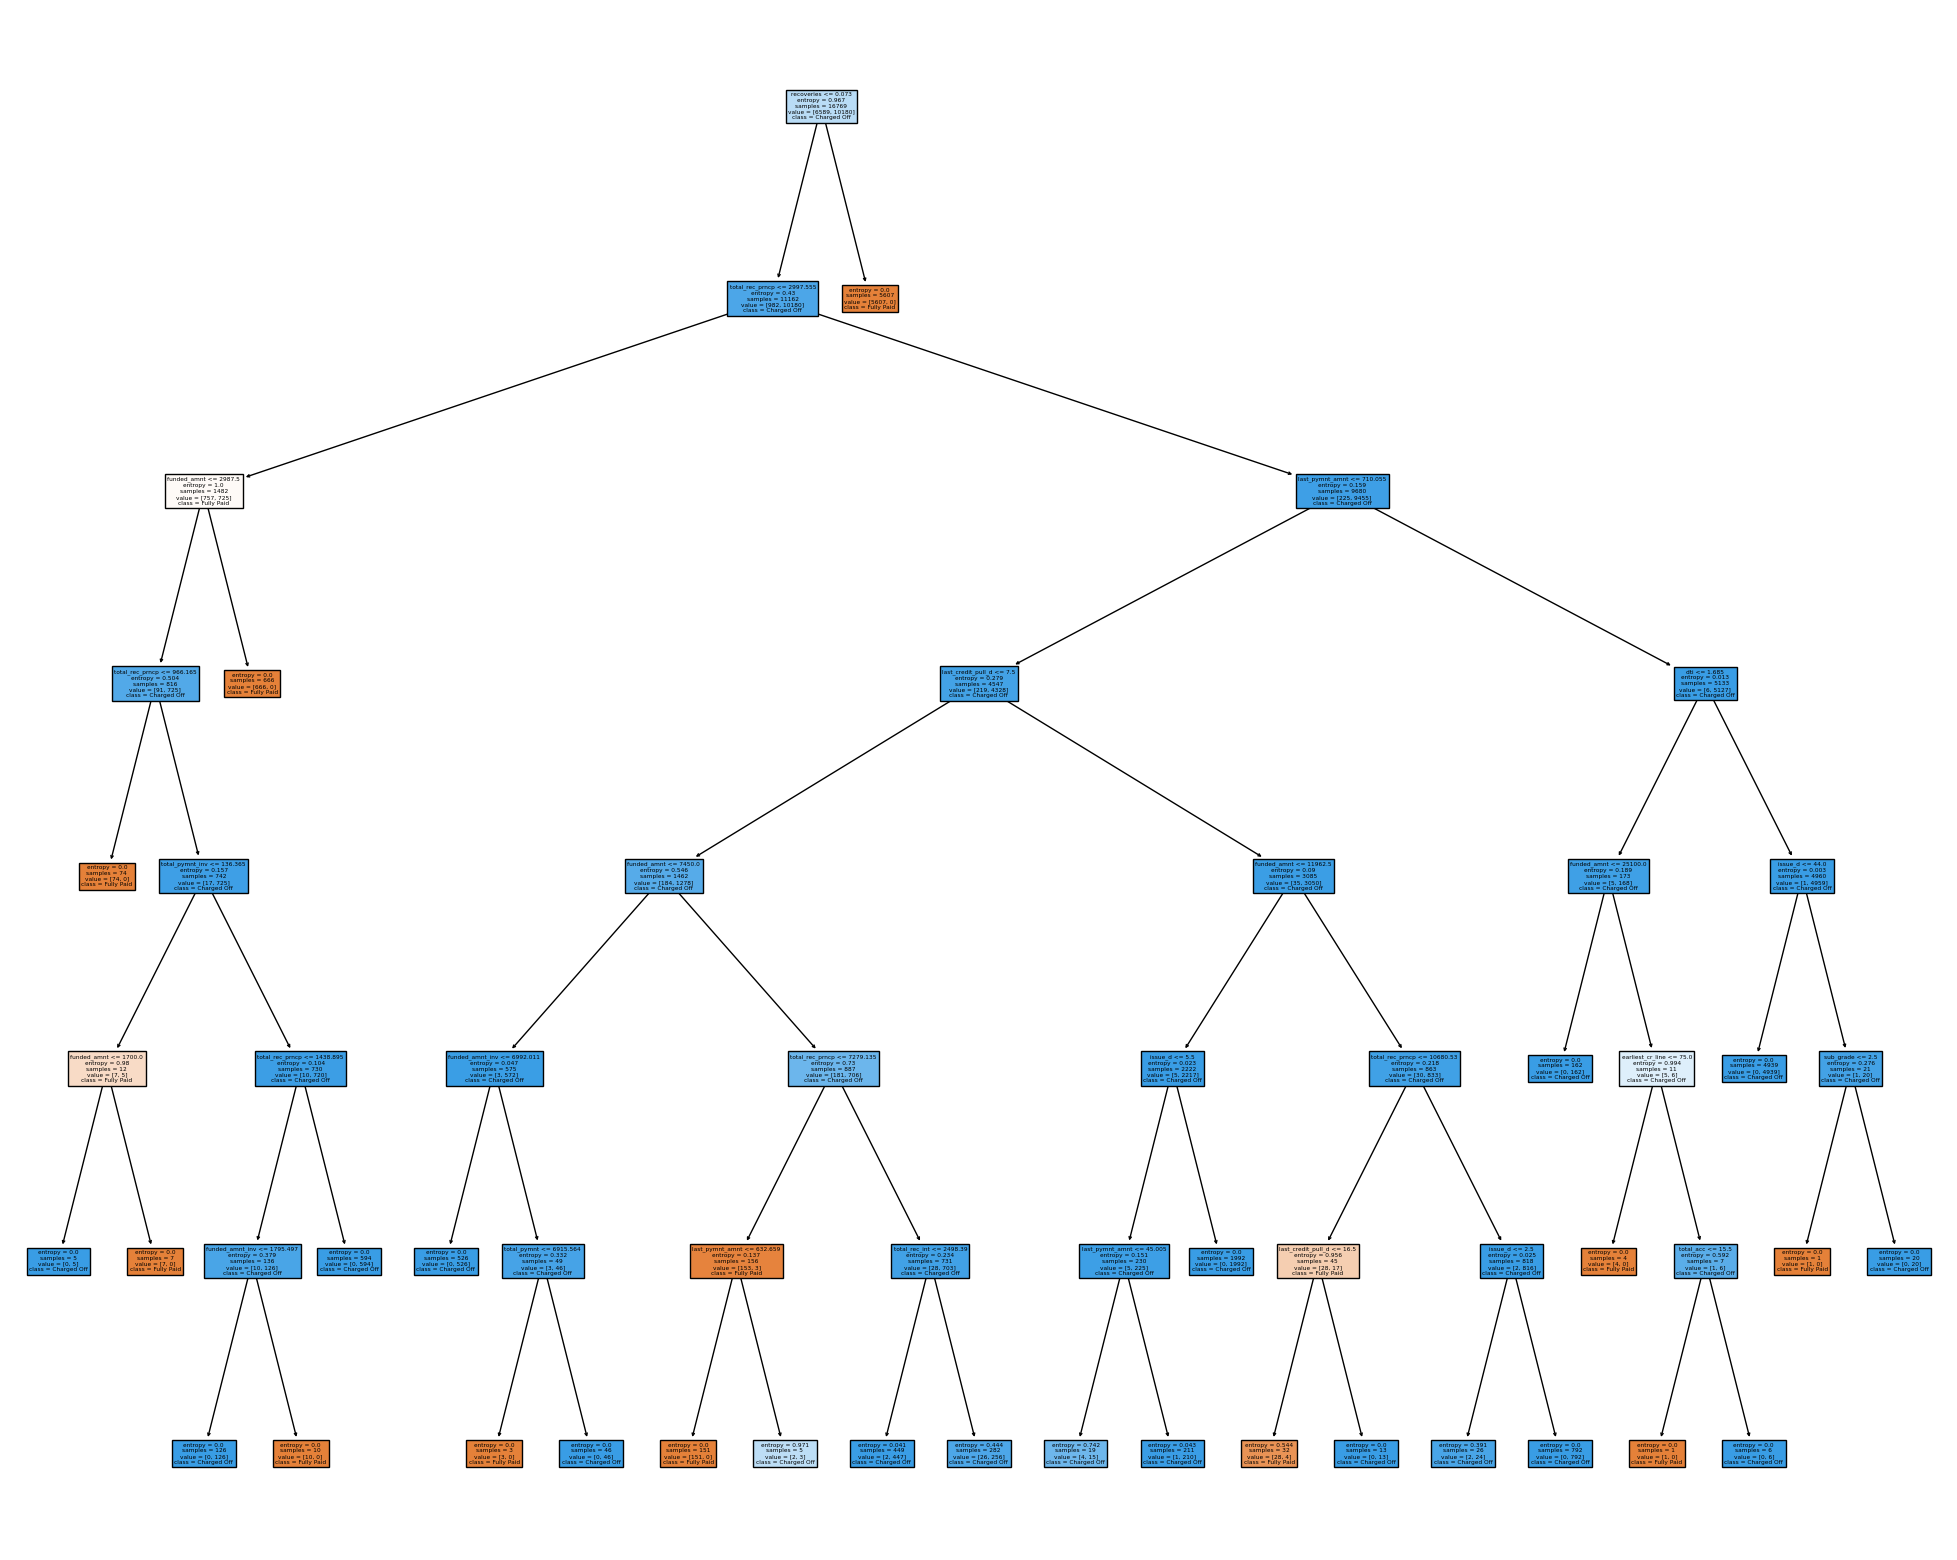

In [7]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,  
                   class_names=y_train_labeled.unique(),
                   filled=True)

### Testing Data performance: Precisiom, Recall, F1-Score

In [8]:
print("====== Testing Data Confusion Matrix ======")
print(confusion_matrix(y_test, y_pred_final))

====== Testing Data Confusion Matrix ======
[[1551   82]
 [   7 4969]]


In [9]:
print("====== Testing Data Classification Report ======")
print(classification_report(y_test, y_pred_final))

====== Testing Data Classification Report ======
              precision    recall  f1-score   support

 Charged Off       1.00      0.95      0.97      1633
  Fully Paid       0.98      1.00      0.99      4976

    accuracy                           0.99      6609
   macro avg       0.99      0.97      0.98      6609
weighted avg       0.99      0.99      0.99      6609



### Feature Importance

In [10]:
importance = clf.feature_importances_
for i,v in enumerate(importance):
 print(features[i],':', v)

loan_amnt : 0.0
funded_amnt : 0.07896372293879166
funded_amnt_inv : 0.0038924430374360033
term : 0.0
int_rate : 0.0
grade : 0.0
sub_grade : 0.0003622656634342264
emp_length : 0.0
home_ownership : 0.0
annual_inc : 0.0
verification_status : 0.0
issue_d : 0.002149298403306205
purpose : 0.0
title : 0.0
addr_state : 0.0
dti : 0.0012931692674546845
delinq_2yrs : 0.0
earliest_cr_line : 0.0004242568824493566
inq_last_6mths : 0.0
open_acc : 0.0
pub_rec : 0.0
revol_bal : 0.0
revol_util : 0.0
total_acc : 0.0002586848661162698
out_prncp : 0.0
out_prncp_inv : 0.0
total_pymnt : 0.0010169517323400262
total_pymnt_inv : 0.0018032480745930844
total_rec_prncp : 0.16686099543378252
total_rec_int : 0.0017330997423970517
total_rec_late_fee : 0.0
recoveries : 0.7128926816648048
collection_recovery_fee : 0.0
last_pymnt_d : 0.0
last_pymnt_amnt : 0.01475662568180883
last_credit_pull_d : 0.013592556611285202
collections_12_mths_ex_med : 0.0
pub_rec_bankruptcies : 0.0


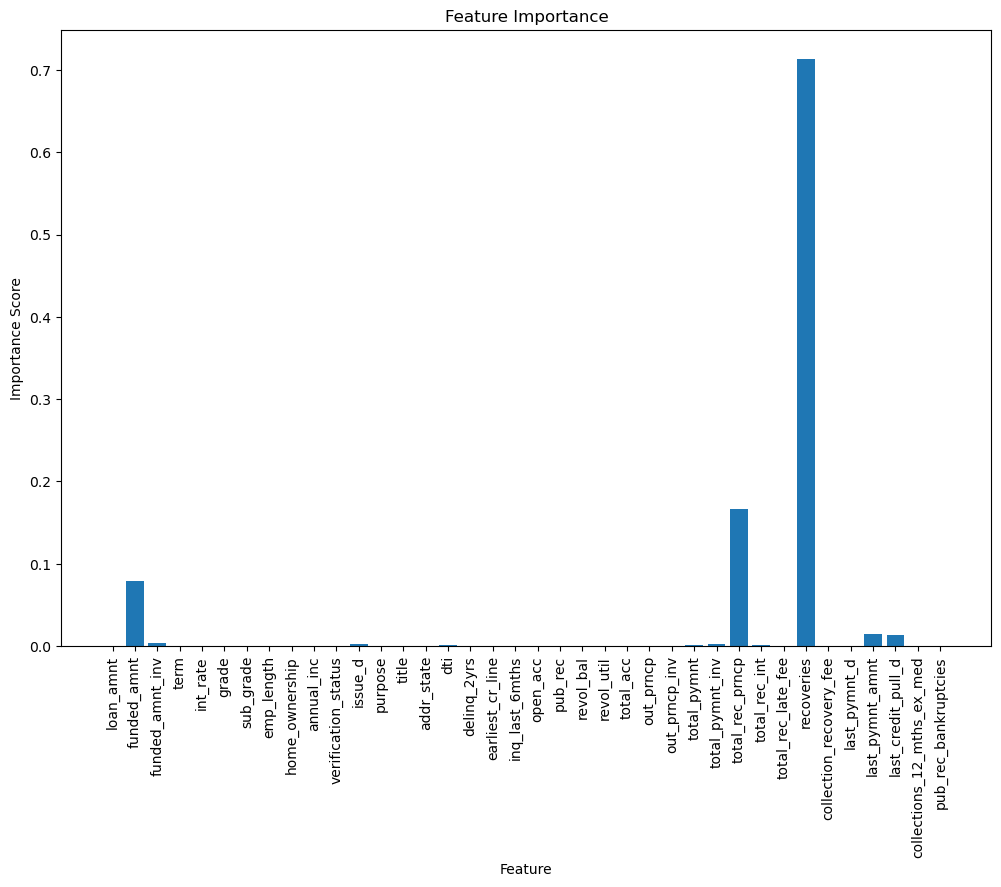

In [11]:
# plot feature importance
plt.figure(figsize=(12,8))
plt.bar(features, importance)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()